In [ ]:
# Install all necessary requirements
%pip install docai-py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Download annotations from Butler using docai library
from docai.annotations import AnnotationClient
from docai.generated.models import ModelTrainingDocumentStatus

# Get your API Key from Butler
API_KEY = "MY_API_KEY"

# Specify the id of the model that you annotated your documents in
MODEL_ID = "MY_MODEL_ID"

# Load annotations from Butler
butler_client = AnnotationClient(API_KEY)
annotations = butler_client.load_annotations(
    model_id=MODEL_ID,
    load_all_pages=True,
    document_status=ModelTrainingDocumentStatus.LABELED
)
print("Loaded {} annotations".format(len(annotations.training_documents)))

Loaded 50 annotations


In [ ]:
from docai.annotations import normalize_ner_annotation_for_layoutlm

# Convert annotations into NER format so they can be used
# to train LayoutLMv3 with Hugging Face
annotations_as_ner = annotations.as_ner(as_iob2=True)

# Normalize NER annotations by 1000 to match LayoutLM expected bounding box format
annotations_as_ner = list(map(normalize_ner_annotation_for_layoutlm, annotations_as_ner))

In [ ]:
# Create Hugging Face Dataset
from datasets import Dataset
dataset = Dataset.from_list(annotations_as_ner)
print(dataset)

Dataset({
    features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
    num_rows: 50
})


In [ ]:
# First, lets create a few helper variables for use below
from datasets.features import ClassLabel
from docai.annotations import get_ner_tags_for_model

model_ner_tags = get_ner_tags_for_model(annotations.model_details)
print(f'Tags: {model_ner_tags["tags"]}')

label_list = model_ner_tags["tags"]
class_label = ClassLabel(names=label_list)
id2label = {k: v for k,v in enumerate(label_list)}
label2id = {v: k for k,v in enumerate(label_list)}
column_names = dataset.column_names

# Split dataset into train/test
dataset = dataset.train_test_split(test_size=0.1)

Tags: ['O', 'B-Address', 'B-Date_of_Birth', 'B-Drivers_License_Number', 'B-Expiration_Date', 'B-First_Name', 'B-Last_Name', 'I-Address', 'I-Date_of_Birth', 'I-Drivers_License_Number', 'I-Expiration_Date', 'I-First_Name', 'I-Last_Name']


In [ ]:
# Load the microsoft/layoutlmv3-base processor from the Hugging Face hub
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

def convert_ner_tags_to_id(ner_tags):
  return [label2id[ner_tag] for ner_tag in ner_tags]

# This function is used to put the Dataset in its final format for training LayoutLM
def prepare_dataset(annotations):
    images = annotations['image']
    words = annotations['tokens']
    boxes = annotations['bboxes']
    # Map over labels and convert to numeric id for each ner_tag
    ner_tags = [convert_ner_tags_to_id(ner_tags) for ner_tags in annotations['ner_tags']]

    encoding = processor(images, words, boxes=boxes, word_labels=ner_tags, truncation=True, padding="max_length")

    return encoding

Downloading:   0%|          | 0.00/275 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/856 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [ ]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# Define features for use training the model
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

# Prepare our train & eval dataset
train_dataset = dataset["train"].map(
    prepare_dataset,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = dataset["test"].map(
    prepare_dataset,
    batched=True,
    remove_columns=column_names,
    features=features,
)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
from docai.training import generate_layoutlm_compute_eval_metric_fn

# Use this utility from the docai SDK to create a function that can
# be used to calculate the evaluation metrics while training
compute_eval_metrics = generate_layoutlm_compute_eval_metric_fn(
    ner_labels=label_list,
    metric_name="seqeval",
    return_entity_level_metrics=False
)

In [ ]:
'''
Define our model, as well as the TrainingArguments which includes all the
hyperparameters related to training.
'''

from transformers import TrainingArguments, Trainer
from transformers import LayoutLMv3ForTokenClassification
from transformers.data.data_collator import default_data_collator

MODEL_NAME = 'us_dl_model'

model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    id2label=id2label,
    label2id=label2id)

training_args = TrainingArguments(
    output_dir=MODEL_NAME,
    max_steps=1000,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=1e-5,
    evaluation_strategy="steps",
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1")

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_eval_metrics,
)

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
max_steps is given, it will override any value given in num_train_epochs


In [ ]:
'''
Train the model!
'''
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 45
  Num Epochs = 44
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 1000
  Number of trainable parameters = 125927565
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:764: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.293060,0.592593,0.533333,0.561404,0.932203
200,No log,0.183972,0.896552,0.866667,0.881356,0.976271
300,No log,0.097078,0.964286,0.900000,0.931034,0.979661
400,No log,0.020170,1.000000,1.000000,1.000000,1.000000
500,0.203600,0.012929,1.000000,1.000000,1.000000,1.000000
600,0.203600,0.010103,1.000000,1.000000,1.000000,1.000000
700,0.203600,0.008616,1.000000,1.000000,1.000000,1.000000
800,0.203600,0.008461,1.000000,1.000000,1.000000,1.000000
900,0.203600,0.007098,1.000000,1.000000,1.000000,1.000000
1000,0.009100,0.007054,1.000000,1.000000,1.000000,1.000000


***** Running Evaluation *****
  Num examples = 5
  Batch size = 2
***** Running Evaluation *****
  Num examples = 5
  Batch size = 2
***** Running Evaluation *****
  Num examples = 5
  Batch size = 2
***** Running Evaluation *****
  Num examples = 5
  Batch size = 2
***** Running Evaluation *****
  Num examples = 5
  Batch size = 2
Saving model checkpoint to us_dl_model/checkpoint-500
Configuration saved in us_dl_model/checkpoint-500/config.json
Model weights saved in us_dl_model/checkpoint-500/pytorch_model.bin
Feature extractor saved in us_dl_model/checkpoint-500/preprocessor_config.json
tokenizer config file saved in us_dl_model/checkpoint-500/tokenizer_config.json
Special tokens file saved in us_dl_model/checkpoint-500/special_tokens_map.json
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:764: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Trans

TrainOutput(global_step=1000, training_loss=0.10633785772323609, metrics={'train_runtime': 499.7236, 'train_samples_per_second': 4.002, 'train_steps_per_second': 2.001, 'total_flos': 519453978037248.0, 'train_loss': 0.10633785772323609, 'epoch': 43.48})

In [ ]:
# If you want, log in to the hugging face hub and push your
# model for future use
# from huggingface_hub import notebook_login
# notebook_login()
# model.push_to_hub(repo_id='my/repo-id')

In [ ]:
'''
Run inference on the model using the processor and model from above
'''
from transformers import AutoModelForTokenClassification
import torch

example = dataset["test"][1]
image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
ner_tags = convert_ner_tags_to_id(example["ner_tags"])

encoding = processor(image, words, boxes=boxes, word_labels=ner_tags, return_tensors="pt")

if torch.cuda.is_available():
  encoding.to("cuda")
  model.to("cuda")

with torch.no_grad():
    outputs = model(**encoding)

logits = outputs.logits
predictions = logits.argmax(-1).squeeze().tolist()
labels = encoding.labels.squeeze().tolist()

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:764: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


In [ ]:
'''
Some simple utilities for drawing bboxes on images of Driver's Licenses
'''
from PIL import ImageDraw, ImageFont

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
        return 'other'
    return label

def draw_boxes_on_img(
    preds_or_labels,
    boxes,
    draw,
    image,
    unnormalize = False
):
  label_color_lookup = {
      "drivers_license_number": "green",
      "expiration_date": "blue",
      "date_of_birth": "red",
      "first_name": "orange",
      "last_name": "yellow",
      "address": "purple"
  }

  for pred_or_label, box in zip(preds_or_labels, boxes):
    label = iob_to_label(pred_or_label).lower()

    if label == 'other':
      continue
    else:
      if unnormalize:
        box = unnormalize_box(box, width, height)

      color = label_color_lookup[label]
      draw.rectangle(box, outline=color)
      draw.text((box[0] + 10, box[1] - 10), text=label, fill=color, font=font)

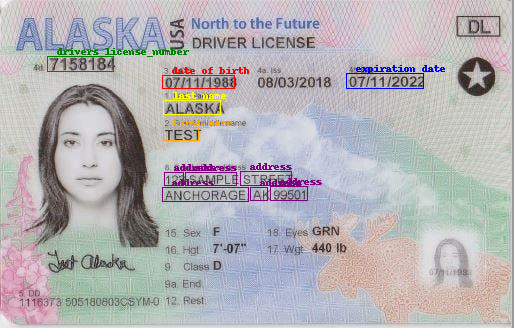

In [ ]:
'''
Draw predictions
'''
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

draw_boxes_on_img(true_predictions, true_boxes, draw, image)
image

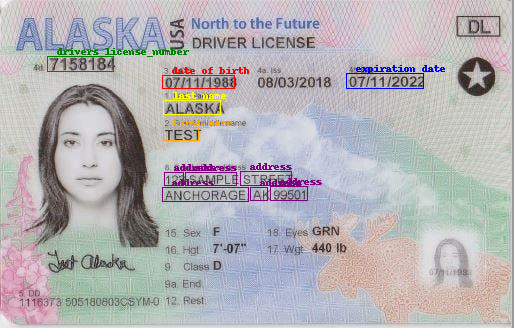

In [ ]:
'''
Compare to ground truch
'''
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

draw_boxes_on_img(example['ner_tags'], example['bboxes'], draw, image, True)

image